### to get this working in full, recon loss needs to be applied component needs to be added to discrim reconstruction

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load dataset

In [2]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/home/AD/tsainbur/anaconda3/envs/py19/lib/python3.6/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [4]:
print(tf.__version__, tfp.__version__)

2.0.0 0.8.0


In [5]:
TRAIN_SIZE=101726
BATCH_SIZE=32
TEST_SIZE=10000
DIMS = (32, 32, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [6]:
DATASET_ID = 'starling'

In [7]:
record_loc = DATA_DIR / 'tfrecords' / "starling_32.tfrecords"

In [8]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [9]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [10]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [11]:
spec, index, indv  = next(iter(dataset))

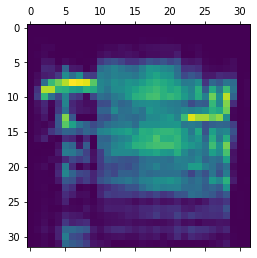

In [12]:
plt.matshow(spec.numpy().reshape(DIMS[:2]))

In [13]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [14]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

### define network

In [15]:
latent_dim = N_Z = 128

encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation=None#tf.nn.sigmoid
    ),
]

discrim_project = [
    tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu
            ),
    tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu
            ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation=None
    ),
    tf.keras.layers.Flatten()
]

discrim_decision = [
    tf.keras.layers.Dense(units=1, activation = None)
]


In [16]:
class VAEGAN(tf.keras.Model):
    """a VAEGAN class for tensorflow
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, beta=1.0, **kwargs):
        super(VAEGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)
        self.disc_project = tf.keras.Sequential(self.discrim_project)
        self.disc_decide = tf.keras.Sequential(self.discrim_decision)

        if not hasattr(self, "enc_optimizer"):
            self.enc_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen)
            # self.dec_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen)
            # self.disc_optimizer = tf.keras.optimizers.Adam(self.get_lr_d)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return mu, sigma

    def decode(self, z, apply_sigmoid=False):
        logits = self.dec(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def discriminate_project(self, x, apply_sigmoid=False):
        logits = self.disc_project(x)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def discriminate_decide(self, x):
        return self.disc_decide(x)

    def discriminate(self, x):
        return self.disc_decide(self.disc_project(x))

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def get_lr_d(self):
        return self.lr_base_disc * self.D_prop

    """def reconstruct(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, apply_sigmoid=True)"""
    
    def reconstruct(self, x):
        mean, _ = self.encode(x)
        #z = self.reparameterize(mean, logvar)
        return self.decode(mean, apply_sigmoid=True)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    """@tf.function
    def compute_loss(self, x):
        # reconstruct x
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(mean)
        # x_logit = self.decode(z)
        # x_probs = tf.sigmoid(x_logit)

        # sample and reconstruct z
        # z_samp = tf.random.normal(shape=(len(x), z.shape[-1]))
        # xg_samp = self.decode(z_samp, apply_sigmoid=True)

        ### pass through discriminator
        # pass generated x through discriminator
        d_xg_samp = self.discriminate(xg_samp)
        # get latent discrim for x
        ld_x = self.discriminate_project(x, apply_sigmoid=True)
        # make decision for x
        d_x = self.discriminate(x)
        # get latent for discrim xg
        ld_xg = self.discriminate_project(x_probs)
        d_xg = self.discriminate_decide(ld_xg)

        # loss for latent
        logpz = log_normal_pdf(z, 0.0, 0.0)
        logqz_x = log_normal_pdf(z, mean, logvar)

        # loss for reconstruction FOR VAEGAN
        VAEGAN_recon = False
        if VAEGAN_recon:
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=ld_xg, labels=ld_x
            )
        else:
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
                logits=x_logit, labels=x
            )

        # logpx_z = -tf.reduce_sum(cross_ent, axis=[1])

        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

        # overall VAE loss
        # elbo_loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        elbo_loss = tf.reduce_mean(tf.square(tf.sigmoid(x_logit) - x))
        # loss for GAN
        disc_real_loss = gan_loss(logits=d_x, is_real=True)
        disc_fake_loss = gan_loss(logits=d_xg_samp, is_real=False)
        gen_fake_loss = gan_loss(logits=d_xg_samp, is_real=True)
        self.D_prop = sigmoid(
            disc_fake_loss - gen_fake_loss, shift=0.0, mult=self.sig_mult
        )

        enc_loss = elbo_loss
        # dec_loss = elbo_loss  # + gen_fake_loss
        # disc_loss = disc_fake_loss + disc_real_loss

        return (
            0,  # self.D_prop,
            tf.reduce_mean(logpx_z),
            tf.reduce_mean(logpz - logqz_x),
            elbo_loss,
            0,  # disc_real_loss,
            0,  # disc_fake_loss,
            0,  # gen_fake_loss,
            enc_loss,
            0,  # dec_loss,
            0,  # disc_loss,
        )"""
    
    @tf.function
    def compute_loss(self, x):
        # reconstruct x
        mean, _ = self.encode(x)
        #z = self.reparameterize(mean, logvar)
        x_prob = self.decode(mean, apply_sigmoid = True)
        
        # loss for latent
        #logpz = log_normal_pdf(z, 0.0, 0.0)
        #logqz_x = log_normal_pdf(z, mean, logvar)

        
        #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
        #    logits=x_logit, labels=x
        #)
        #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

        # overall VAE loss
        # elbo_loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        
        elbo_loss = tf.reduce_mean(tf.square(x_prob - x))

        enc_loss = elbo_loss


        return enc_loss

    """@tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            (_, _, _, _, _, _, _, enc_loss, dec_loss, disc_loss) = self.compute_loss(x)

        enc_gradients = enc_tape.gradient(enc_loss, self.enc.trainable_variables)
        dec_gradients = dec_tape.gradient(dec_loss, self.dec.trainable_variables)
        disc_gradients = disc_tape.gradient(
            disc_loss,
            self.disc_project.trainable_variables
            + self.disc_decide.trainable_variables,
        )

        return enc_gradients, dec_gradients, disc_gradients
    
    @tf.function
    def apply_gradients(self, enc_gradients, dec_gradients, disc_gradients):
        self.enc_optimizer.apply_gradients(
            zip(enc_gradients, self.enc.trainable_variables)
        )
        self.dec_optimizer.apply_gradients(
            zip(dec_gradients, self.dec.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc_project.trainable_variables
            + self.disc_decide.trainable_variables)
        )
        
    def train_net(self, x):
        enc_gradients, dec_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(enc_gradients, dec_gradients, disc_gradients)
        """

    # @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as enc_tape:
            enc_loss = self.compute_loss(x)

        enc_gradients = enc_tape.gradient(
            enc_loss, self.enc.trainable_variables + self.dec.trainable_variables
        )

        return enc_gradients

    # @tf.function
    def apply_gradients(self, enc_gradients):
        self.enc_optimizer.apply_gradients(
            zip(enc_gradients, self.enc.trainable_variables)
        )

    def train_net(self, x):
        enc_gradients = self.compute_gradients(x)
        self.apply_gradients(enc_gradients)

In [17]:
class AE(tf.keras.Model):
    """a VAEGAN class for tensorflow
    
    Extends:
        tf.keras.Model
    """

    def __init__(self, beta=1.0, **kwargs):
        super(AE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)
        self.disc_project = tf.keras.Sequential(self.discrim_project)
        self.disc_decide = tf.keras.Sequential(self.discrim_decision)

        if not hasattr(self, "enc_optimizer"):
            self.enc_optimizer = tf.keras.optimizers.Adam(self.lr_base_gen)
            self.disc_optimizer = tf.keras.optimizers.Adam(self.get_lr_d)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return mu, sigma

    def decode(self, z, apply_sigmoid=False):
        logits = self.dec(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, apply_sigmoid=True)

    def discriminate_project(self, x, apply_sigmoid=False):
        logits = self.disc_project(x)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def discriminate_decide(self, x):
        return self.disc_decide(x)

    def discriminate(self, x):
        return self.disc_decide(self.disc_project(x))

    def get_lr_d(self):
        return self.lr_base_disc * self.D_prop

    @tf.function
    def compute_loss(self, x):

        #### Autoencoder part

        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        x_probs = tf.sigmoid(x_logit)

        # loss for latent
        logpz = log_normal_pdf(z, 0.0, 0.0)
        logqz_x = log_normal_pdf(z, mean, logvar)

        # loss for reconstruction
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=tf.keras.layers.Flatten()(x_logit),
            labels=tf.keras.layers.Flatten()(x),
        )

        #### GAN PART
        # sample and reconstruct z
        z_samp = tf.random.normal(shape=(len(x), z.shape[-1]))
        xg_samp = self.decode(z_samp, apply_sigmoid=True)

        ### pass through discriminator
        # pass generated x through discriminator
        d_xg_samp = self.discriminate(xg_samp)
        # get latent discrim for x
        ld_x = self.discriminate_project(x, apply_sigmoid=True)
        # make decision for x
        d_x = self.discriminate(x)
        # get latent for discrim xg
        ld_xg = self.discriminate_project(x_probs)
        d_xg = self.discriminate_decide(ld_xg)

        # oveall loss for VAE
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1])
        #elbo_loss = tf.reduce_mean(cross_ent)
        elbo_loss = -tf.reduce_mean(logpx_z + (logpz - logqz_x))

        # losses for GAN
        disc_real_loss = gan_loss(logits=d_x, is_real=True)
        disc_fake_loss = gan_loss(logits=d_xg_samp, is_real=False)
        gen_fake_loss = gan_loss(logits=d_xg_samp, is_real=True)
        self.D_prop = sigmoid(
            disc_fake_loss - gen_fake_loss, shift=0.0, mult=self.sig_mult
        )

        # just descriptive
        latent_loss = - tf.reduce_mean(logpz - logqz_x)
        recon_loss = -tf.reduce_mean(logpx_z)

        # net losses
        enc_loss = elbo_loss
        dec_loss = elbo_loss
        disc_loss = disc_fake_loss + disc_real_loss

        return (
            enc_loss,
            dec_loss,
            disc_loss,
            self.D_prop,
            latent_loss,
            recon_loss,
            disc_real_loss,
            disc_fake_loss,
            gen_fake_loss,
        )

    def compute_gradients(self, x):
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            losses = self.compute_loss(x)
            enc_loss = losses[0]
            dec_loss = losses[1]
            disc_loss = losses[2]

        enc_gradients = enc_tape.gradient(enc_loss, self.enc.trainable_variables+self.dec.trainable_variables)
        disc_gradients = disc_tape.gradient(
            disc_loss,
            self.disc_project.trainable_variables
            + self.disc_decide.trainable_variables,
        )

        return enc_gradients, disc_gradients

    def apply_gradients(self, enc_gradients, disc_gradients):
        self.enc_optimizer.apply_gradients(
            zip(enc_gradients, self.enc.trainable_variables + self.dec.trainable_variables)
        )

        self.disc_optimizer.apply_gradients(
            zip(
                disc_gradients,
                self.disc_project.trainable_variables
                + self.disc_decide.trainable_variables,
            )
        )
    
    @tf.function
    def train_net(self, x):
        enc_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients( enc_gradients, disc_gradients)

In [18]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [19]:
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
                
        Arguments:
            logits {[type]} -- output of discriminator
        
        Keyword Arguments:
            isreal {bool} -- whether labels should be 0 (fake) or 1 (real) (default: {True})
        """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels, logits))

def sigmoid(x, shift=0.0, mult=20):
    """ squashes a value with a sigmoid
    """
    return tf.constant(1.0) / (
        tf.constant(1.0) + tf.exp(-tf.constant(1.0) * (x * mult))
    )

### create network

In [20]:
tf.keras.backend.clear_session()

In [21]:
# model
model = AE(
    enc = encoder,
    dec = decoder,
    discrim_project=discrim_project, 
    discrim_decision=discrim_decision,
    enc_optimizer = tf.keras.optimizers.Adam(1e-2),
    disc_optimizer = tf.keras.optimizers.RMSprop(1e-3),
    sig_mult = 10, 
)

In [22]:
model.train_net(example_data)

In [23]:
enc_gradients, disc_gradients = model.compute_gradients(example_data)

In [24]:
[[tf.reduce_sum(i) for i in grads] for grads in [enc_gradients, disc_gradients]]

[[<tf.Tensor: id=8663, shape=(), dtype=float32, numpy=-19.870377>,
  <tf.Tensor: id=8665, shape=(), dtype=float32, numpy=-1.7455678>,
  <tf.Tensor: id=8667, shape=(), dtype=float32, numpy=-183.75638>,
  <tf.Tensor: id=8669, shape=(), dtype=float32, numpy=-24.062996>,
  <tf.Tensor: id=8671, shape=(), dtype=float32, numpy=-201.02542>,
  <tf.Tensor: id=8673, shape=(), dtype=float32, numpy=-37.122196>,
  <tf.Tensor: id=8675, shape=(), dtype=float32, numpy=1766.3821>,
  <tf.Tensor: id=8677, shape=(), dtype=float32, numpy=118.828285>,
  <tf.Tensor: id=8679, shape=(), dtype=float32, numpy=-2946.9072>,
  <tf.Tensor: id=8681, shape=(), dtype=float32, numpy=1259.2627>,
  <tf.Tensor: id=8683, shape=(), dtype=float32, numpy=31216.016>,
  <tf.Tensor: id=8685, shape=(), dtype=float32, numpy=429.2266>,
  <tf.Tensor: id=8687, shape=(), dtype=float32, numpy=26796.896>,
  <tf.Tensor: id=8689, shape=(), dtype=float32, numpy=208.45746>,
  <tf.Tensor: id=8691, shape=(), dtype=float32, numpy=22322.492>,
  <

In [25]:
def plot_reconstruction(model, example_data, BATCH_SIZE, N_Z, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)), apply_sigmoid=True)
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys#, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()

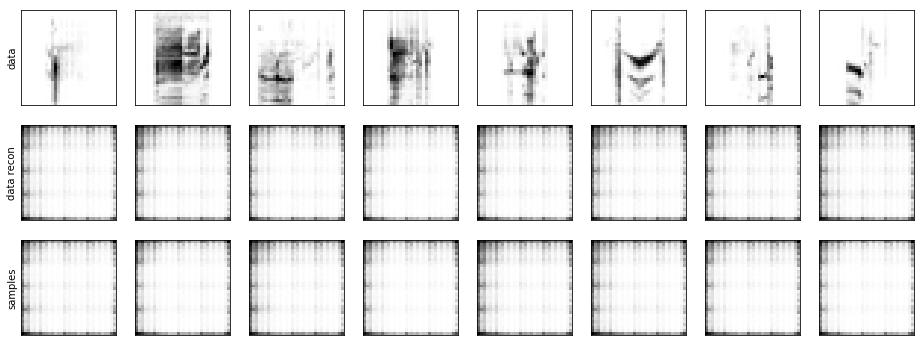

In [26]:
plot_reconstruction(model, example_data, BATCH_SIZE, N_Z=N_Z)

In [27]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns=[
    'enc_loss',
    'dec_loss',
    'disc_loss',
    'D_prop',
    'latent_loss',
    'recon_loss',
    'disc_real_loss',
    'disc_fake_loss',
    'gen_fake_loss',
])

In [28]:
N_TRAIN_BATCHES = 1000
N_TEST_BATCHES = 100

In [29]:
n_epochs = 5000
epoch = 0

In [30]:
def plot_losses(losses):
    cols = list(losses.columns)
    fig, axs = plt.subplots(ncols = len(cols), figsize= (len(cols)*4, 4))
    for ci, col in enumerate(cols):
        if len(cols) == 1:
            ax = axs
        else:
            ax = axs.flatten()[ci]
        ax.plot(losses[col].values)
        ax.set_title(col)
    plt.show()

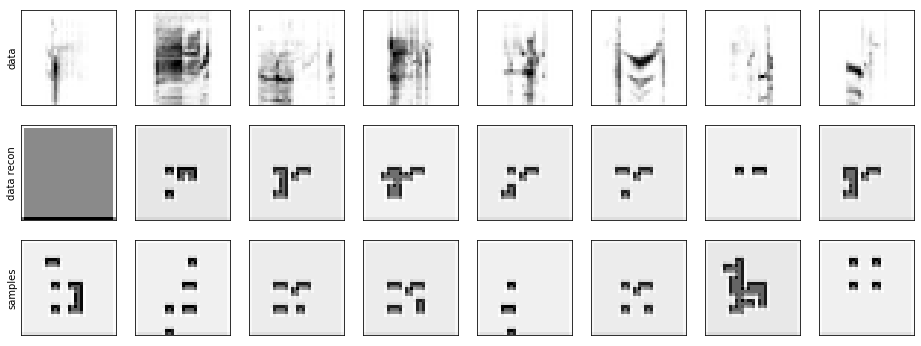

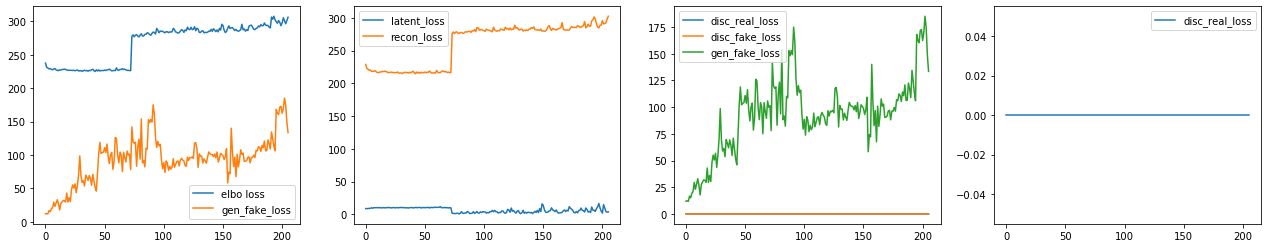

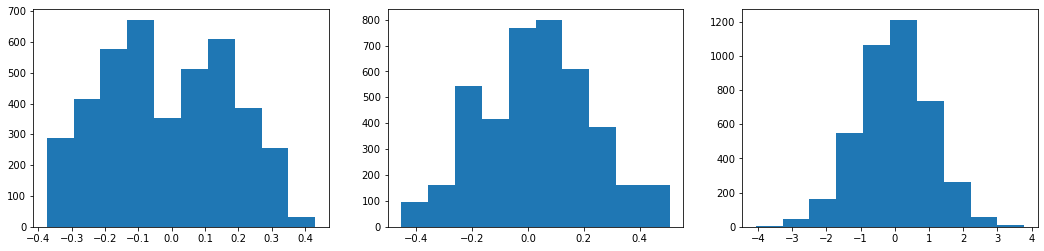

In [ ]:
for epoch in range(epoch, n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        x = tf.cast(tf.reshape(train_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        model.train_net(x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        loss.append(model.compute_loss(x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()

    plot_reconstruction(model, example_data, BATCH_SIZE, N_Z=latent_dim)
    
    # plot losses
    fig, axs = plt.subplots(ncols=4, figsize=(22,4))
    # elbo loss vs GAN loss
    axs[0].plot(losses.latent_loss + losses.recon_loss, label = 'elbo loss')
    axs[0].plot(losses.gen_fake_loss, label = 'gen_fake_loss')
    axs[0].legend()
    # latent loss vs AE loss
    axs[1].plot(losses.latent_loss, label = 'latent_loss')
    axs[1].plot(losses.recon_loss, label = 'recon_loss')
    axs[1].legend()
    # discriminator vs generator loss
    axs[2].plot(losses.disc_real_loss, label = 'disc_real_loss')
    axs[2].plot(losses.disc_fake_loss, label = 'disc_fake_loss')
    axs[2].plot(losses.gen_fake_loss, label = 'gen_fake_loss')
    axs[2].legend()

    # D prop
    axs[3].plot(losses.D_prop, label = 'disc_real_loss')
    axs[3].legend() 
    
    # plot Z
    mean, logvar = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)
    z = model.reparameterize(mean, logvar).numpy()
    fig, axs = plt.subplots(ncols=3, figsize=(18,4))
    axs[0].hist(mean.numpy().flatten())
    axs[1].hist(logvar.numpy().flatten())
    axs[2].hist(z.flatten())
    plt.show()

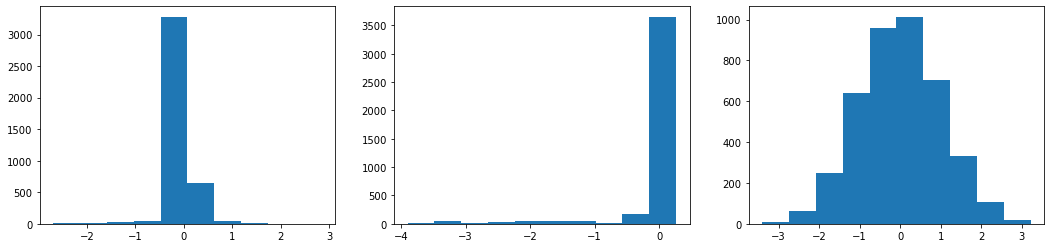

In [32]:
mean, logvar = tf.split(model.enc(example_data), num_or_size_splits=2, axis=1)
z = model.reparameterize(mean, logvar).numpy()
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
axs[0].hist(mean.numpy().flatten())
axs[1].hist(logvar.numpy().flatten())
axs[2].hist(z.flatten())
plt.show()

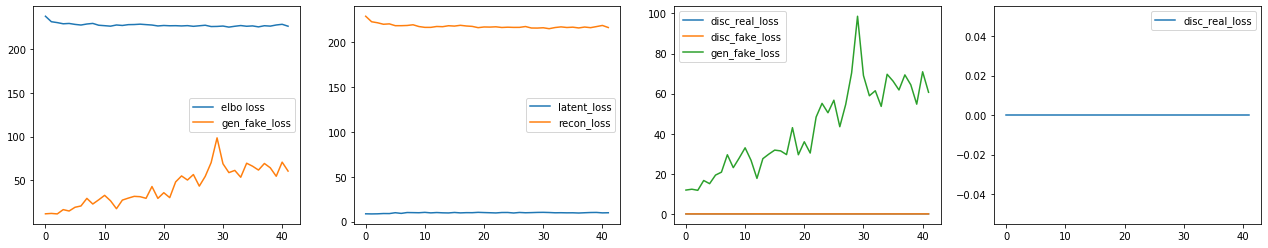

In [33]:
fig, axs = plt.subplots(ncols=4, figsize=(22,4))
# elbo loss vs GAN loss
axs[0].plot(losses.latent_loss + losses.recon_loss, label = 'elbo loss')
axs[0].plot(losses.gen_fake_loss, label = 'gen_fake_loss')
axs[0].legend()
# latent loss vs AE loss
axs[1].plot(losses.latent_loss, label = 'latent_loss')
axs[1].plot(losses.recon_loss, label = 'recon_loss')
axs[1].legend()
# discriminator vs generator loss
axs[2].plot(losses.disc_real_loss, label = 'disc_real_loss')
axs[2].plot(losses.disc_fake_loss, label = 'disc_fake_loss')
axs[2].plot(losses.gen_fake_loss, label = 'gen_fake_loss')
axs[2].legend()

# D prop
axs[3].plot(losses.D_prop, label = 'disc_real_loss')
axs[3].legend()

In [ ]:
plt.hist(mean.numpy().flatten());

In [ ]:
plt.hist(sig.numpy().flatten());

In [ ]:
reparam = model.reparameterize(mean, sig)

In [ ]:
plt.hist(reparam.numpy().flatten());